# Question 2

In [9]:
%pip install tensorflow==2.0.0
%pip install keras==2.3.1

import nltk
import re
import numpy as np
import itertools
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.models import Input, Model
from keras.layers import Dense
from scipy import sparse

download dataset:

In [10]:
nltk.download('reuters')
from nltk.corpus import reuters
!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

Streaming output truncated to the last 5000 lines.
  inflating: /root/nltk_data/corpora/reuters/training/2231  
  inflating: /root/nltk_data/corpora/reuters/training/2232  
  inflating: /root/nltk_data/corpora/reuters/training/2234  
  inflating: /root/nltk_data/corpora/reuters/training/2236  
  inflating: /root/nltk_data/corpora/reuters/training/2237  
  inflating: /root/nltk_data/corpora/reuters/training/2238  
  inflating: /root/nltk_data/corpora/reuters/training/2239  
  inflating: /root/nltk_data/corpora/reuters/training/2240  
  inflating: /root/nltk_data/corpora/reuters/training/2244  
  inflating: /root/nltk_data/corpora/reuters/training/2246  
  inflating: /root/nltk_data/corpora/reuters/training/2247  
  inflating: /root/nltk_data/corpora/reuters/training/2249  
  inflating: /root/nltk_data/corpora/reuters/training/225  
  inflating: /root/nltk_data/corpora/reuters/training/2251  
  inflating: /root/nltk_data/corpora/reuters/training/2252  
  inflating: /root/nltk_data/corpor

pre process data:

In [11]:
reuters_words = [" ".join(reuters.words(fid)) for fid in reuters.fileids(categories='crude')] 
dataset = reuters_words[:100]

utility.py:

In [12]:
def create_unique_word_dict(text:list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict    

def text_preprocessing(
    text:list,
    punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
    stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will']
    )->list:
    """
    A method to preproces text
    """
    for x in text.lower(): 
        if x in punctuations: 
            text = text.replace(x, "")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list 
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x!='']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text

# Functions to find the most similar word 
def euclidean(vec1:np.array, vec2:np.array) -> float:
    """
    A function to calculate the euclidean distance between two vectors
    """
    return np.sqrt(np.sum((vec1 - vec2)**2))

def find_similar(word:str, embedding_dict:dict, top_n=10)->list:
    """
    A method to find the most similar word based on the learnt embeddings
    """
    dist_dict = {}
    word_vector = embedding_dict.get(word, [])
    if len(word_vector) > 0:
        for key, value in embedding_dict.items():
            if key!=word:
                dist = euclidean(word_vector, value)
                dist_dict.update({
                    key: dist
                })

        return sorted(dist_dict.items(), key=lambda x: x[1])[0:top_n]       

master.py:

In [13]:
# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

for text in dataset:

    # Cleaning the text
    text = text_preprocessing(text)

    # Appending to the all text list
    all_text += text 

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

unique_word_dict = create_unique_word_dict(all_text)

# Defining the number of features (unique words)
n_words = len(unique_word_dict)

# Getting all the unique words 
words = list(unique_word_dict.keys())

# Creating the X and Y matrices using one hot encoding
X = []
Y = []

for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    # Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s
X = sparse.csr_matrix(X)
Y = sparse.csr_matrix(Y)

56416it [00:01, 54043.74it/s]


In [14]:
# Defining the size of the embedding
embed_size = 2

# Defining the neural network
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
# Optimizing the network weights
model.fit(
    x=X, 
    y=Y, 
    batch_size=256,
    epochs=20
    )

Epoch 1/20
56416/56416 [==============================] - 8s 149us/step - loss: 7.7908 - accuracy: 0.0306
Epoch 2/20
56416/56416 [==============================] - 13s 231us/step - loss: 7.3404 - accuracy: 0.0314
Epoch 3/20
56416/56416 [==============================] - 10s 184us/step - loss: 6.8760 - accuracy: 0.0304
Epoch 4/20
56416/56416 [==============================] - 7s 119us/step - loss: 6.6739 - accuracy: 0.0323
Epoch 5/20
56416/56416 [==============================] - 7s 119us/step - loss: 6.6293 - accuracy: 0.0332
Epoch 6/20
56416/56416 [==============================] - 7s 118us/step - loss: 6.6155 - accuracy: 0.0332
Epoch 7/20
56416/56416 [==============================] - 7s 121us/step - loss: 6.6078 - accuracy: 0.0332
Epoch 8/20
56416/56416 [==============================] - 7s 119us/step - loss: 6.6027 - accuracy: 0.0332
Epoch 9/20
56416/56416 [==============================] - 7s 119us/step - loss: 6.5988 - accuracy: 0.0332
Epoch 10/20
56416/56416 [===================

Cannot create output folder: [Errno 17] File exists: '/content\\output'


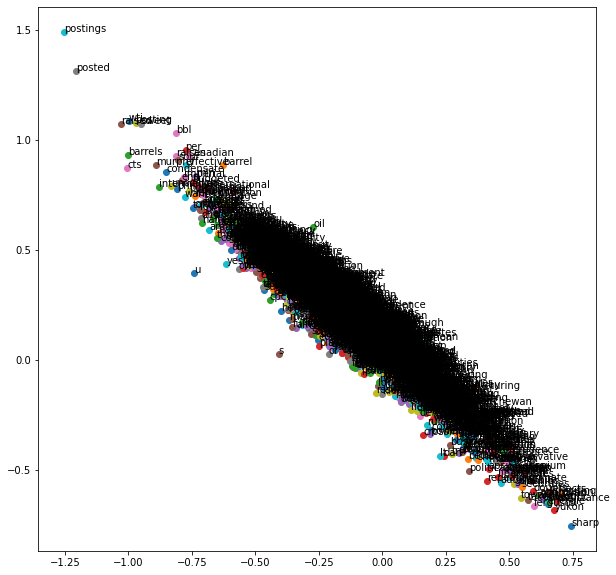

In [15]:
# The input layer 
weights = model.get_weights()[0]

# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })

# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in list(unique_word_dict.keys()):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))       

# Saving the embedding vector to a txt file
try:
    os.mkdir(f'{os.getcwd()}\\output')        
except Exception as e:
    print(f'Cannot create output folder: {e}')

with open(f'{os.getcwd()}\\output\\embedding.txt', 'w') as f:
    for key, value in embedding_dict.items():
        try:
            f.write(f'{key}: {value}\n')   
        except Exception as e:
            print(f'Cannot write word {key} to dict: {e}')   

plot new words just like the code:

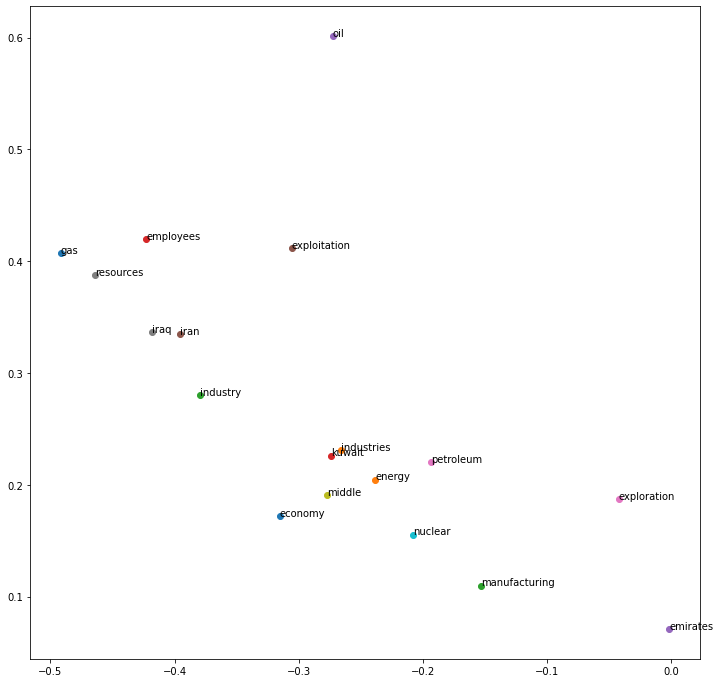

In [16]:
weights = model.get_weights()[0]

embedding_dict = {}
for word in words: 
    embedding_dict.update({ word: weights[unique_word_dict.get(word)]})

question_words = [
    'gas', 'energy', 'industry', 'kuwait', 'oil', 'iran', 'petroleum', 'iraq',
    'middle', 'nuclear', 'economy', 'industries', 'manufacturing', 'employees',
    'emirates', 'exploitation', 'exploration', 'resources']


plt.figure(figsize=(12, 12))
for word in question_words:
    coord = embedding_dict.get(word)
    if coord is None:
        continue
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1])) 

find similarity with my words:

In [22]:
my_words = ['japan', 'decrease', 'lake', 'shell', 'kilolitres', 'iranians', 'year']

for word in my_words:
    similarity = find_similar(word, embedding_dict, 5)
    print("similar with word '{}' :".format(word))
    print([s[0] for s in similarity])
    print("************************************************************************ \n")

similar with word 'japan' :
['search', 'reflect', 'oreffice', 'cancelled', 'monday']
************************************************************************ 

similar with word 'decrease' :
['needs', 'megalitres', 'predicted', 'cgp', 'costing']
************************************************************************ 

similar with word 'lake' :
['produced', 'courts', 'their', 'slight', 'addition']
************************************************************************ 

similar with word 'shell' :
['gas', 'adherence', 'espinosa', 'nine', 'ago']
************************************************************************ 

similar with word 'kilolitres' :
['properties', 'supplied', 'pzl', 'saturday', 'enhance']
************************************************************************ 

similar with word 'iranians' :
['far', 'colon', 'puerto', 'exported', 'demonstrated']
************************************************************************ 

similar with word 'year' :
['noting', 'employe

# Question 3

In [1]:
from tensorflow.keras.datasets.mnist import load_data
(x_train, y_train), (x_test, y_test) = load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [2]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)

print("shape of x_train:", x_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of x_test:", x_test.shape)
print("shape of y_test:", y_test.shape)

shape of x_train: (60000, 28, 28)
shape of y_train: (60000,)
shape of x_test: (10000, 28, 28)
shape of y_test: (10000,)


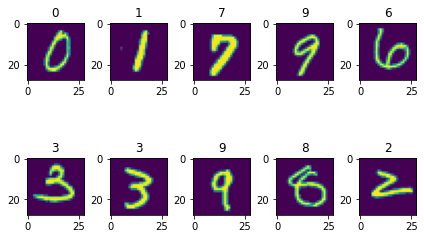

In [3]:
from matplotlib import pyplot as plt

figure = plt.figure()
ax = []
for i in range(10):
  ax.append(figure.add_subplot(2, 5, i+1))
  ax[-1].set_title(y_train[i])
  plt.imshow(x_train[i])
figure.tight_layout(w_pad=0.5)
plt.show()

In [4]:
import numpy as np
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train = x_train/255.0
x_test = x_test/255.0

print("shape of x_train:", x_train.shape)
print("shape of x_test:", x_test.shape)

shape of x_train: (60000, 28, 28, 1)
shape of x_test: (10000, 28, 28, 1)


In [5]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print("shape of y_train:", y_train.shape)
print("shape of y_test:", y_test.shape)

shape of y_train: (60000, 10)
shape of y_test: (10000, 10)


In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential(layers=[
                           Conv2D(32, (3,3), padding='same', activation='relu'),
                           MaxPooling2D(),
                           Conv2D(64, (3,3), padding='same', activation='relu'),
                           MaxPooling2D(),
                           Conv2D(128, (3,3), padding='same', activation='relu'),
                           MaxPooling2D(),
                           Flatten(),
                           Dense(128, activation='relu'),
                           Dense(10, activation='softmax')
])

model.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy'],
)

model.fit(
    x_train,
    y_train,
    batch_size = 64,
    epochs = 10,
)

print("accuracy on train:", round(model.evaluate(x_train, y_train)[1]*100, 2), "%")
print("accuracy on test:", round(model.evaluate(x_test, y_test)[1] * 100, 2), "%")

Epoch 1/10
938/938 [==============================] - 26s 14ms/step - loss: 0.1585 - accuracy: 0.9508
Epoch 2/10
938/938 [==============================] - 11s 12ms/step - loss: 0.0433 - accuracy: 0.9864
Epoch 3/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0296 - accuracy: 0.9904
Epoch 4/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0231 - accuracy: 0.9929
Epoch 5/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0185 - accuracy: 0.9943
Epoch 6/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0145 - accuracy: 0.9955
Epoch 7/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0122 - accuracy: 0.9957
Epoch 8/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0119 - accuracy: 0.9959
Epoch 9/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0090 - accuracy: 0.9972
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.008

In [7]:
from tensorflow.keras.models import Model
import tensorflow as tf
import cv2

def grad_cam(image, layer_name):

  img_array = np.expand_dims(image, axis=0)
  gradModel = Model(
    inputs=[model.inputs],
    outputs=[model.get_layer(layer_name).output,
      model.output])

  with tf.GradientTape() as tape:
    (convOutputs, predictions) = gradModel(img_array)
    loss = predictions[:, 0]

  grads = tape.gradient(loss, convOutputs)

  castConvOutputs = tf.cast(convOutputs > 0, "float32")
  castGrads = tf.cast(grads > 0, "float32")
  guidedGrads = castConvOutputs * castGrads * grads
  
  convOutputs = convOutputs[0]
  guidedGrads = guidedGrads[0]
  
  weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
  cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

  (w, h) = (img_array.shape[2], img_array.shape[1])
  heatmap = cv2.resize(cam.numpy(), (w, h))
  
  numer = heatmap - np.min(heatmap)
  denom = (heatmap.max() - heatmap.min()) + 1e-25
  heatmap = numer / denom
  return heatmap

In [8]:
def superimpose(image, heatmap):
  heatmap = cv2.resize(heatmap, (28, 28))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_GRAY2RGB)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap * 0.5+ image
  superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)
  superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
  return superimposed_img_rgb

In [9]:
def render_images(images):
  columns = int(len(images)/3)
  rows = 3
  fig = plt.figure(figsize=(rows*14, columns))
  for i in range(0, 30, 3):
    fig.add_subplot(rows, columns, i/3 + 1)
    plt.imshow(images[i])
  for i in range(1, 30, 3):
    fig.add_subplot(rows, columns, 10 + (i-1)/3+1)
    plt.imshow(images[i])
  for i in range(2, 30, 3):
    fig.add_subplot(rows, columns, 20 + (i-2)/3+1)
    plt.imshow(images[i])

  figure.tight_layout()
  plt.show()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 128)        0

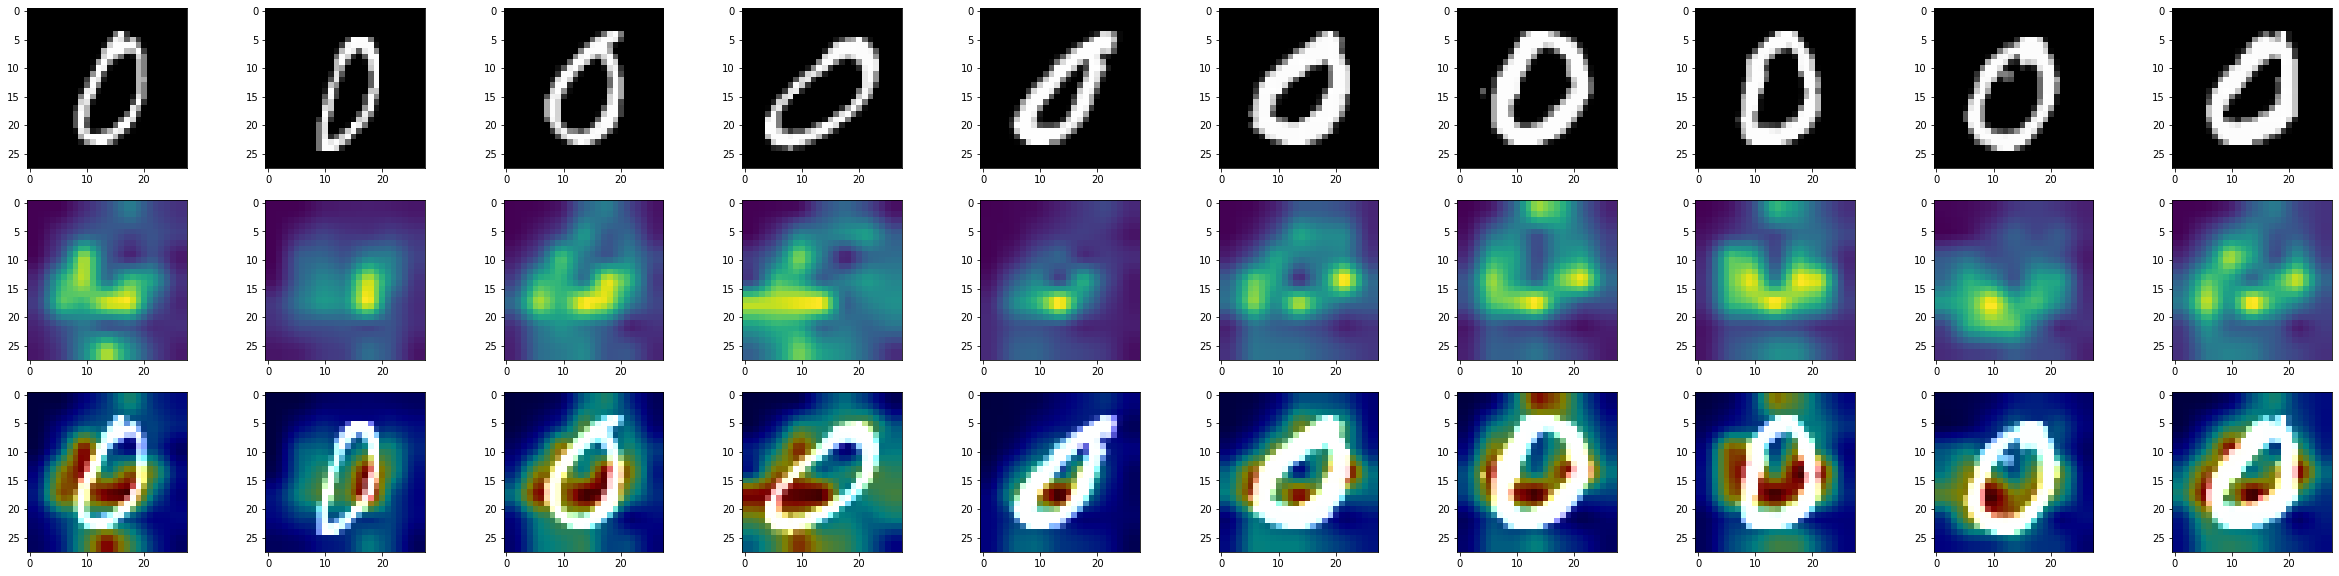



----------------------------------------------




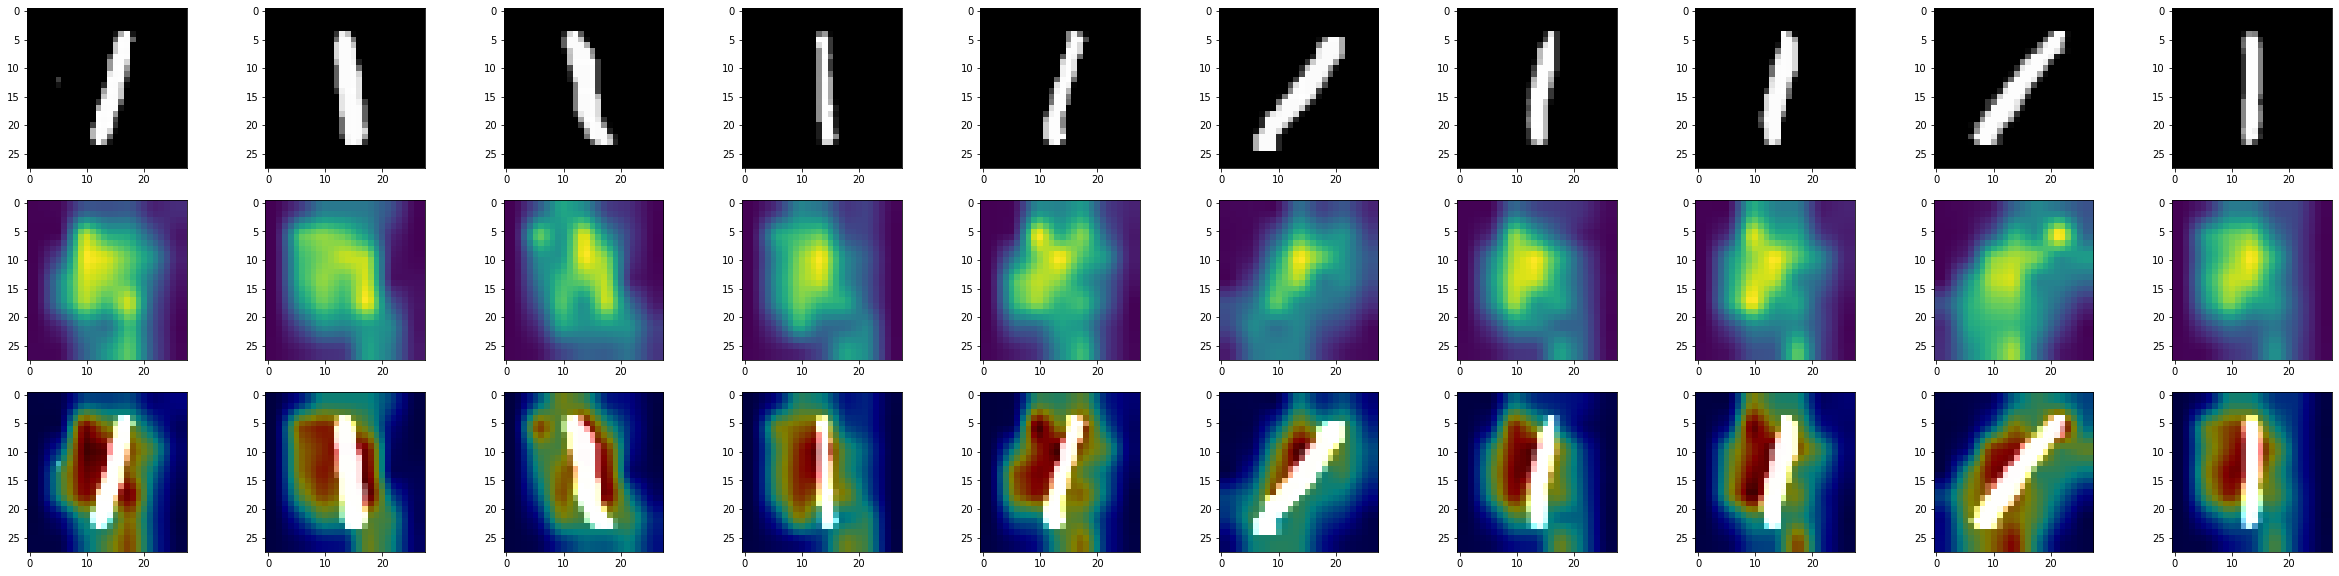



----------------------------------------------




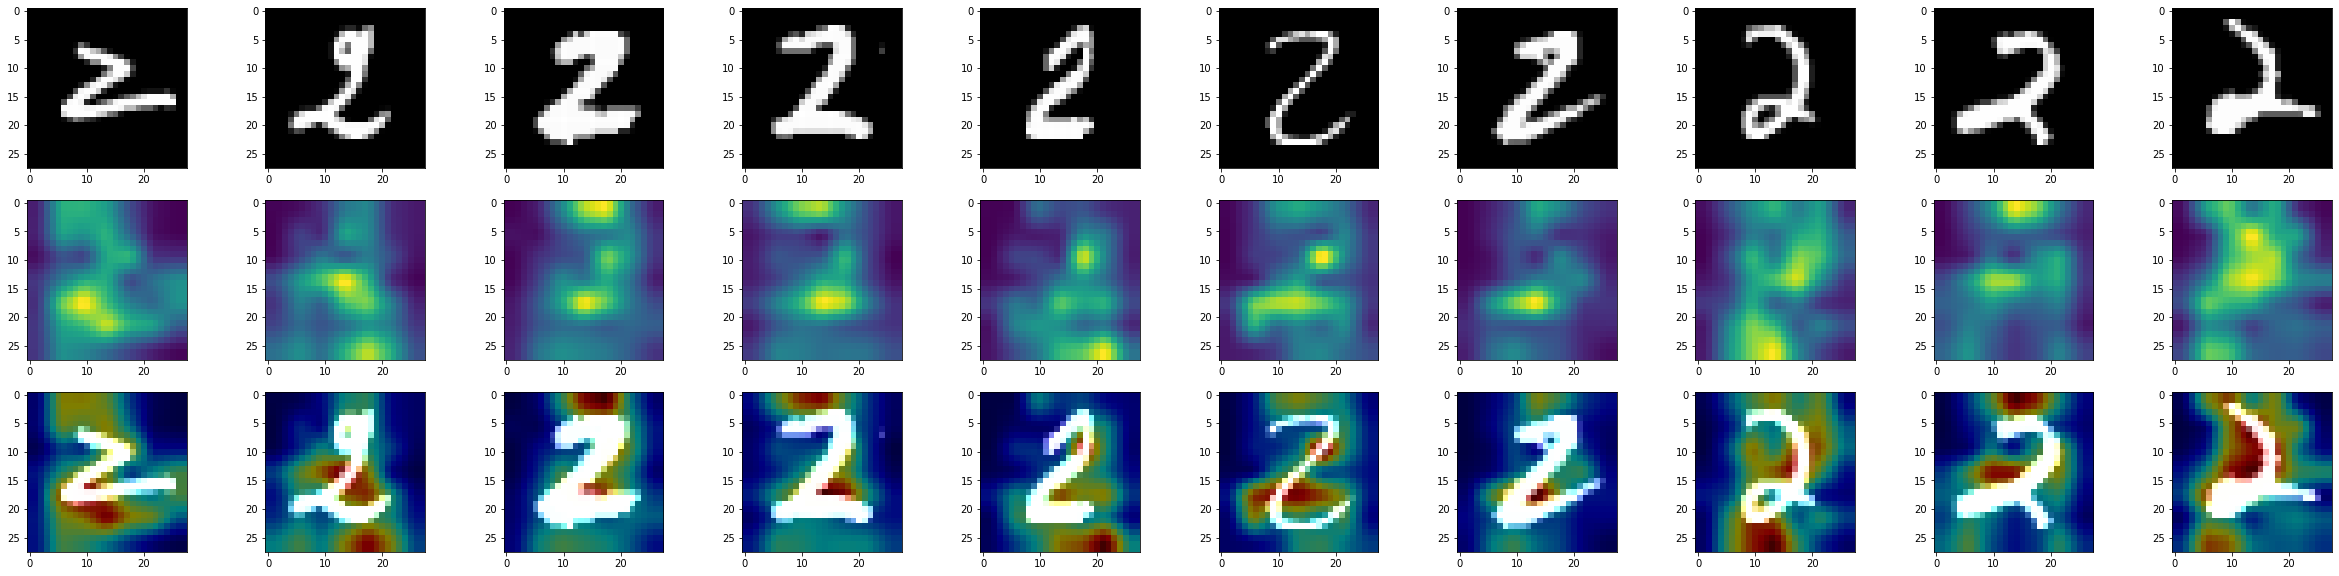



----------------------------------------------




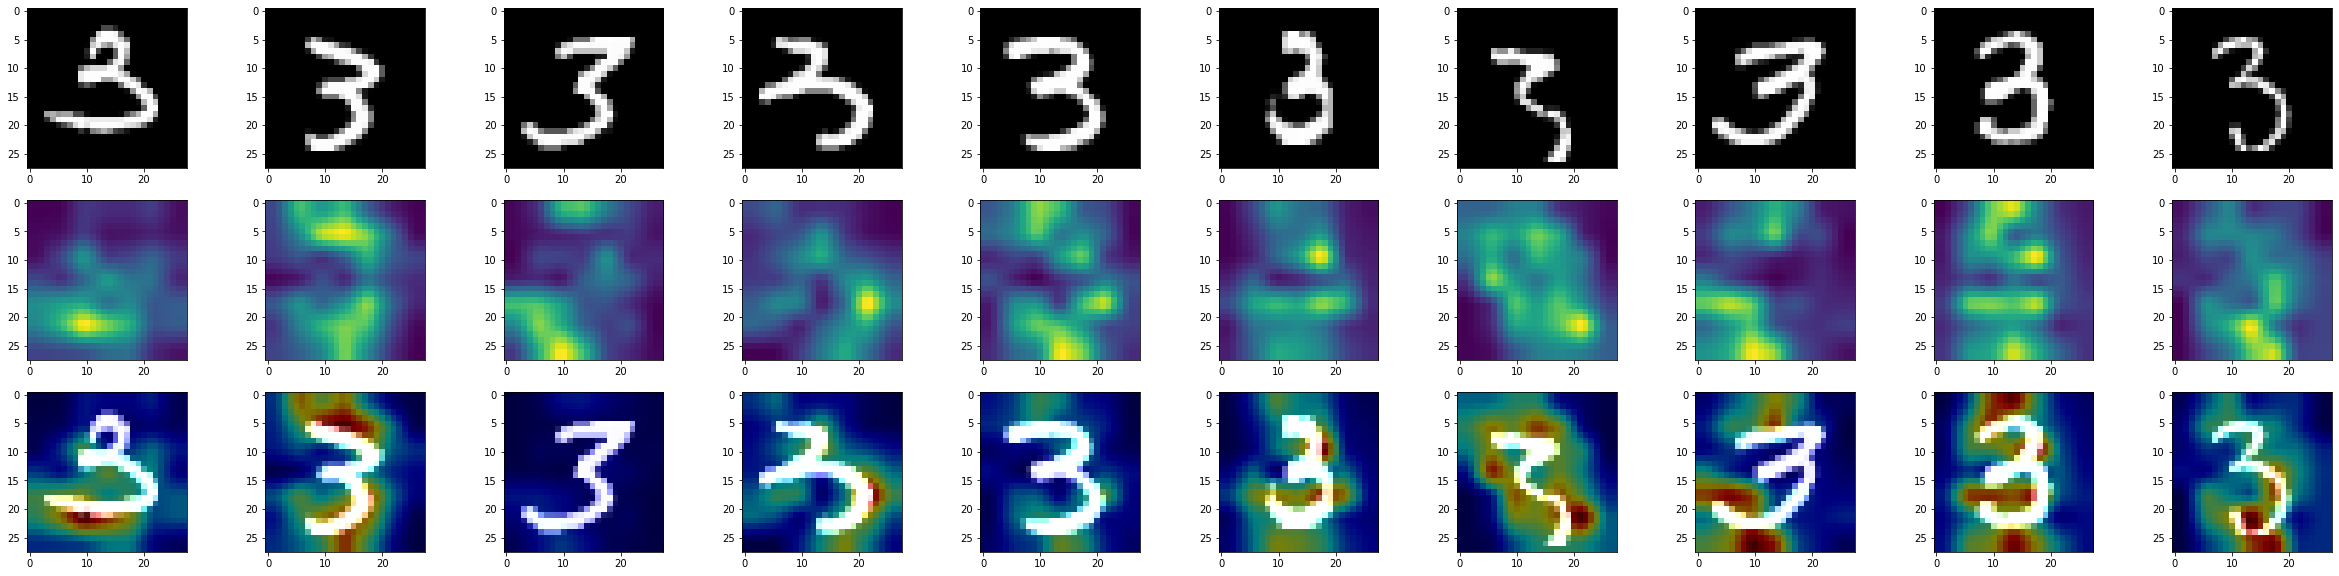



----------------------------------------------




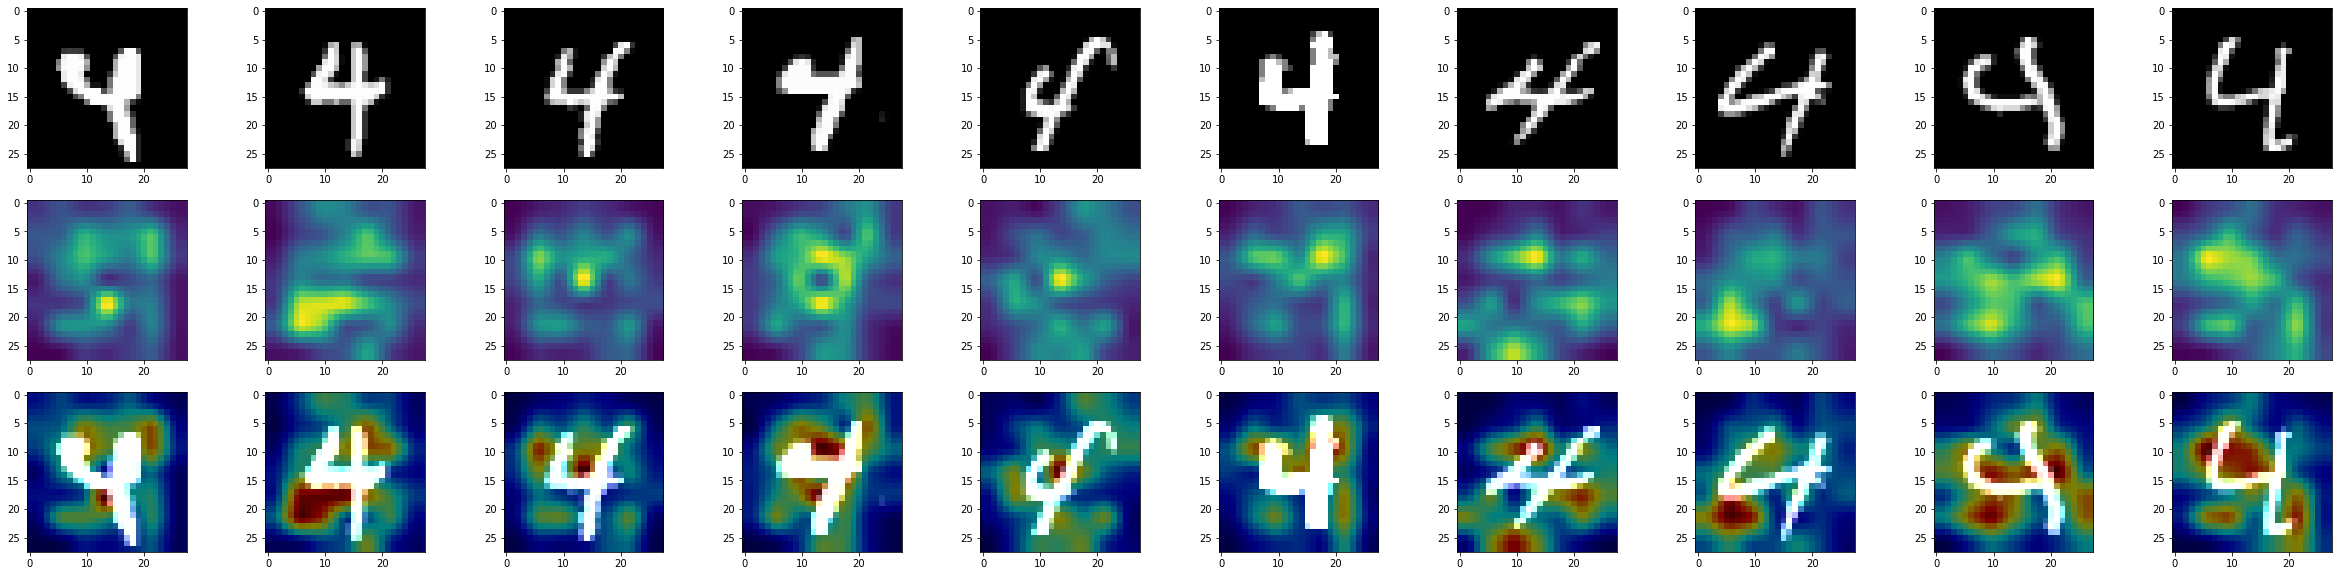



----------------------------------------------




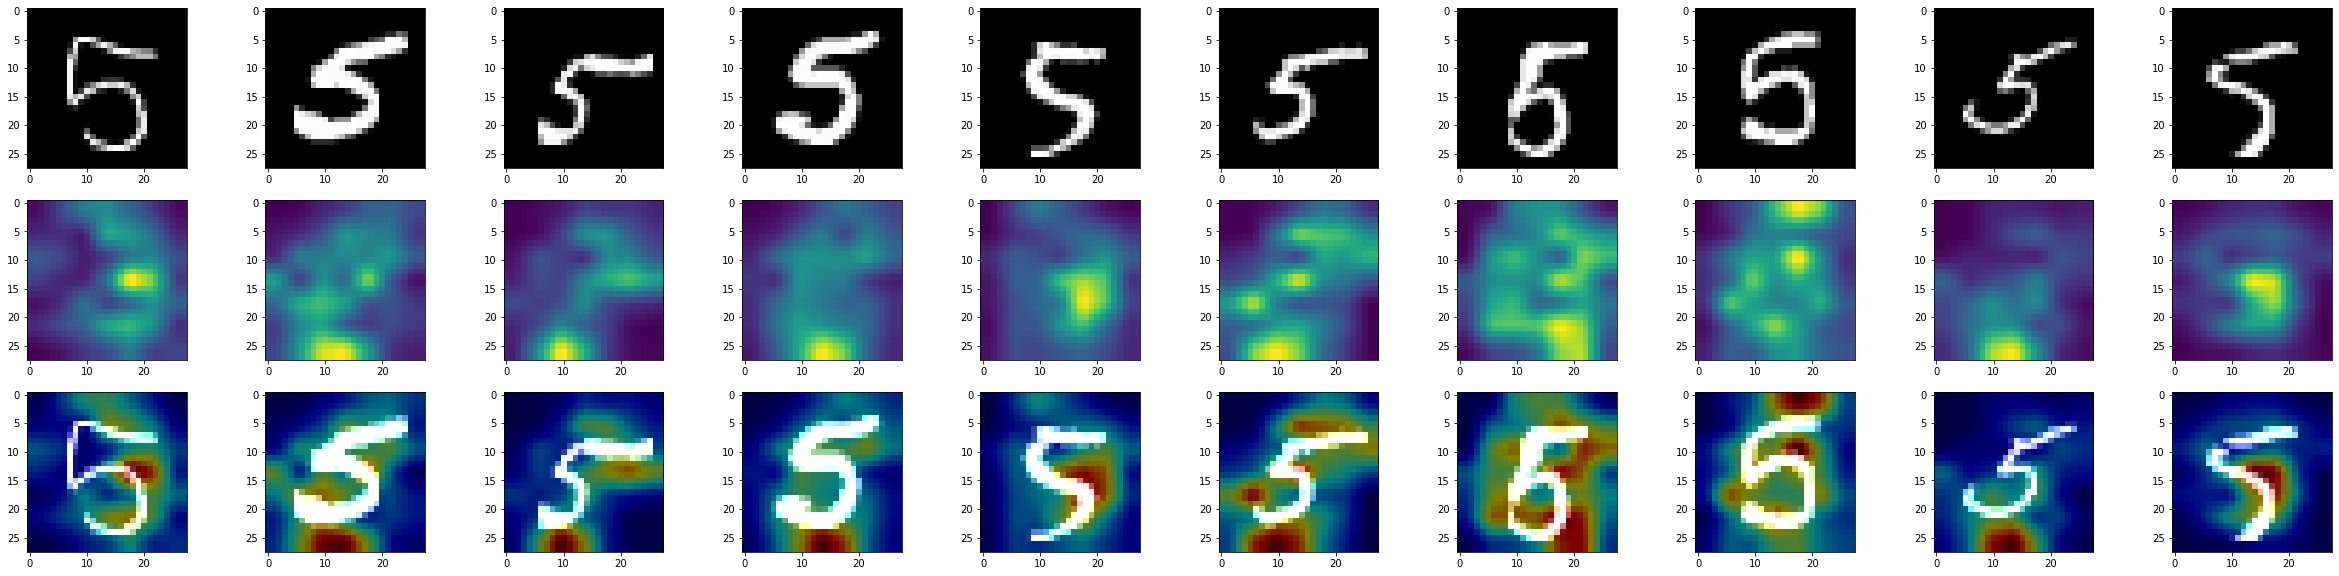



----------------------------------------------




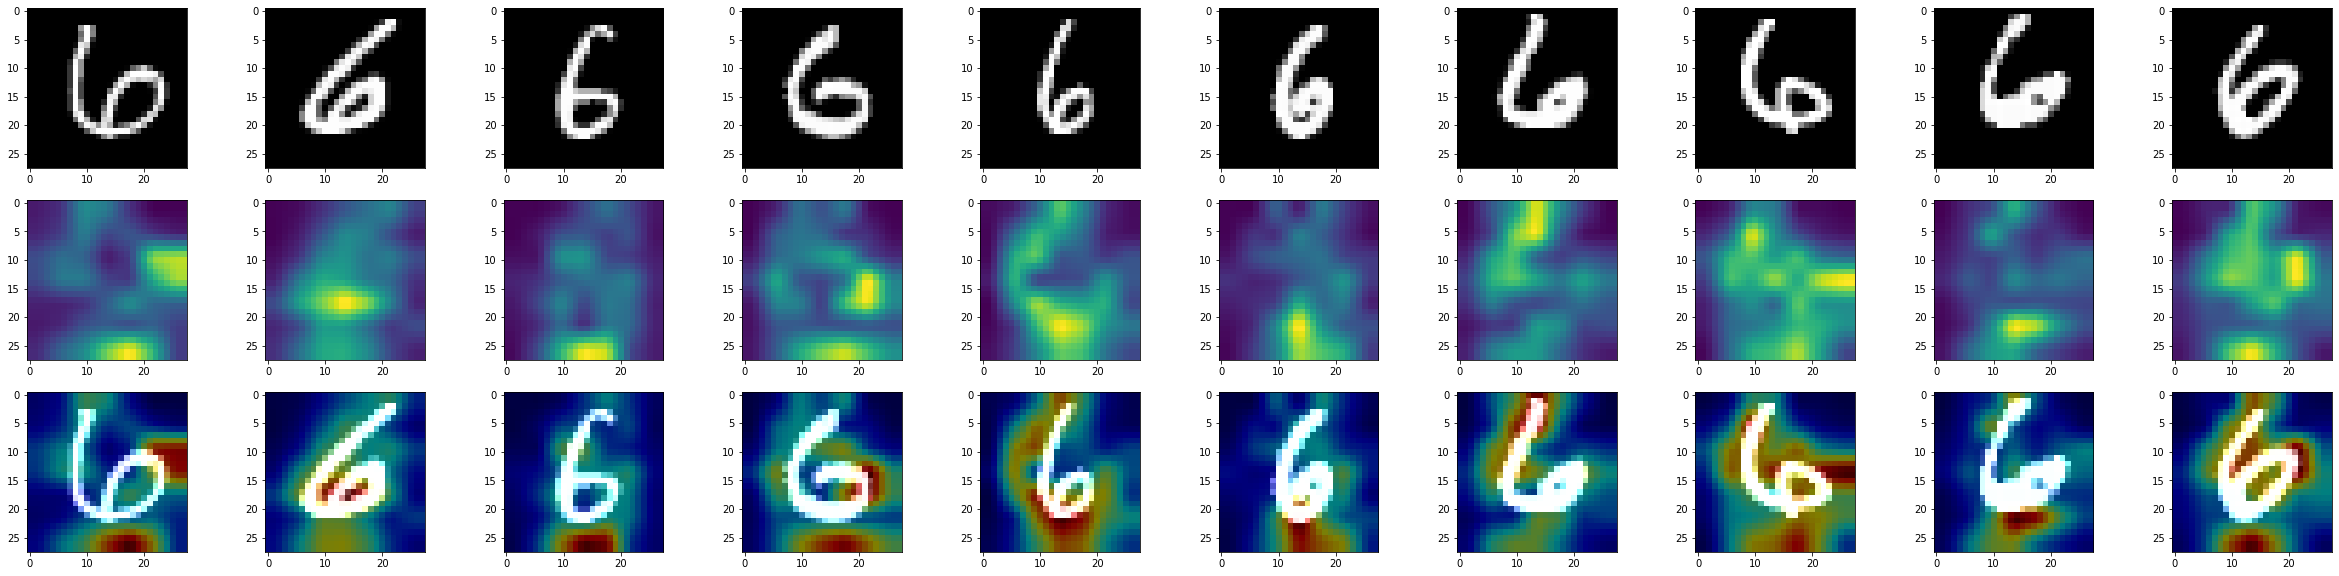



----------------------------------------------




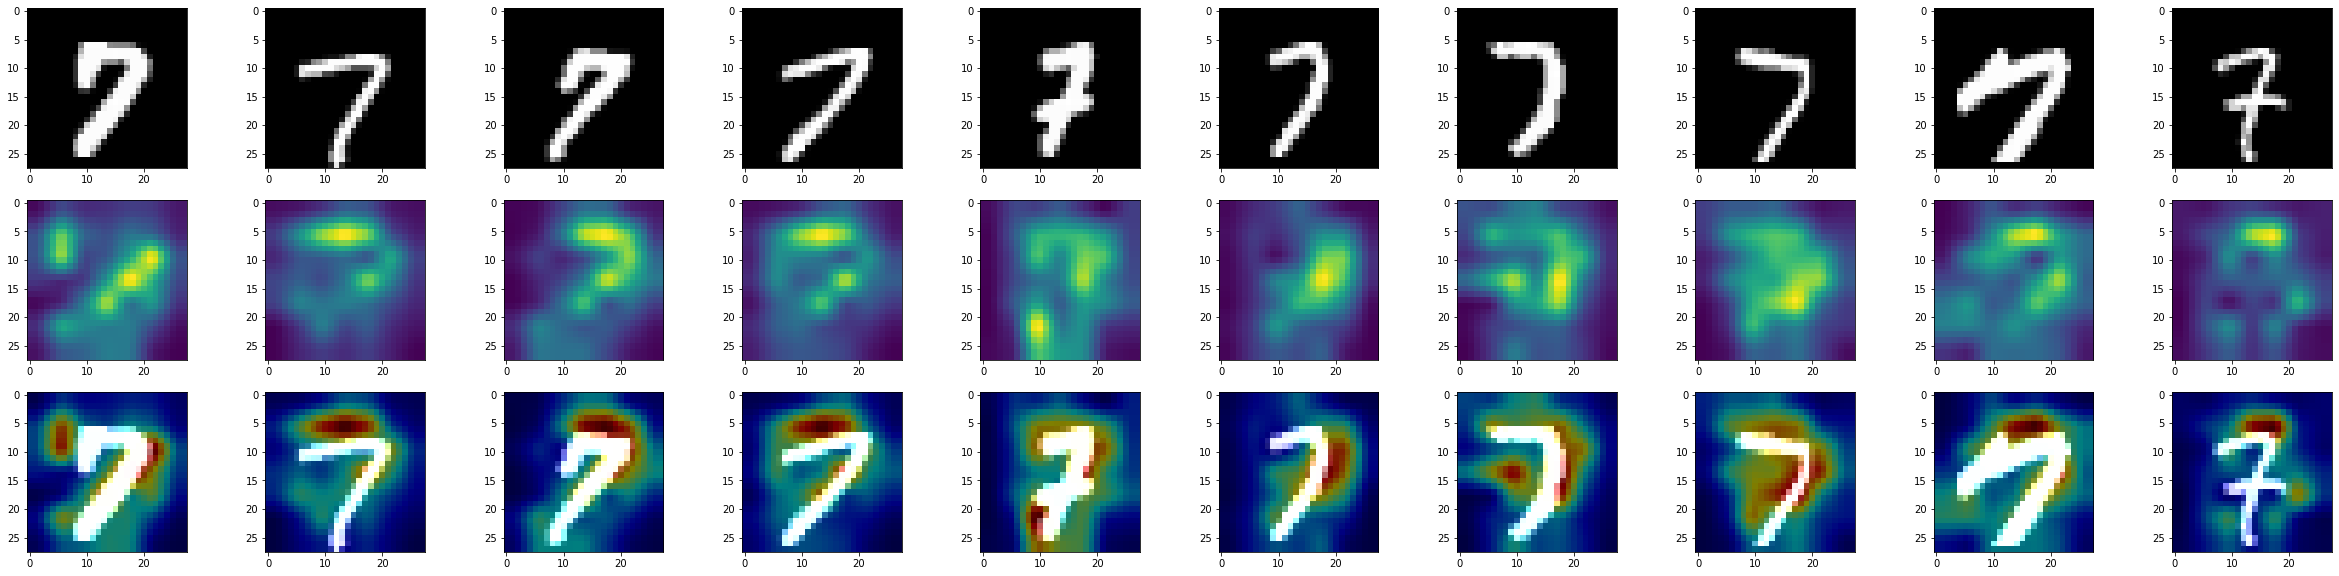



----------------------------------------------




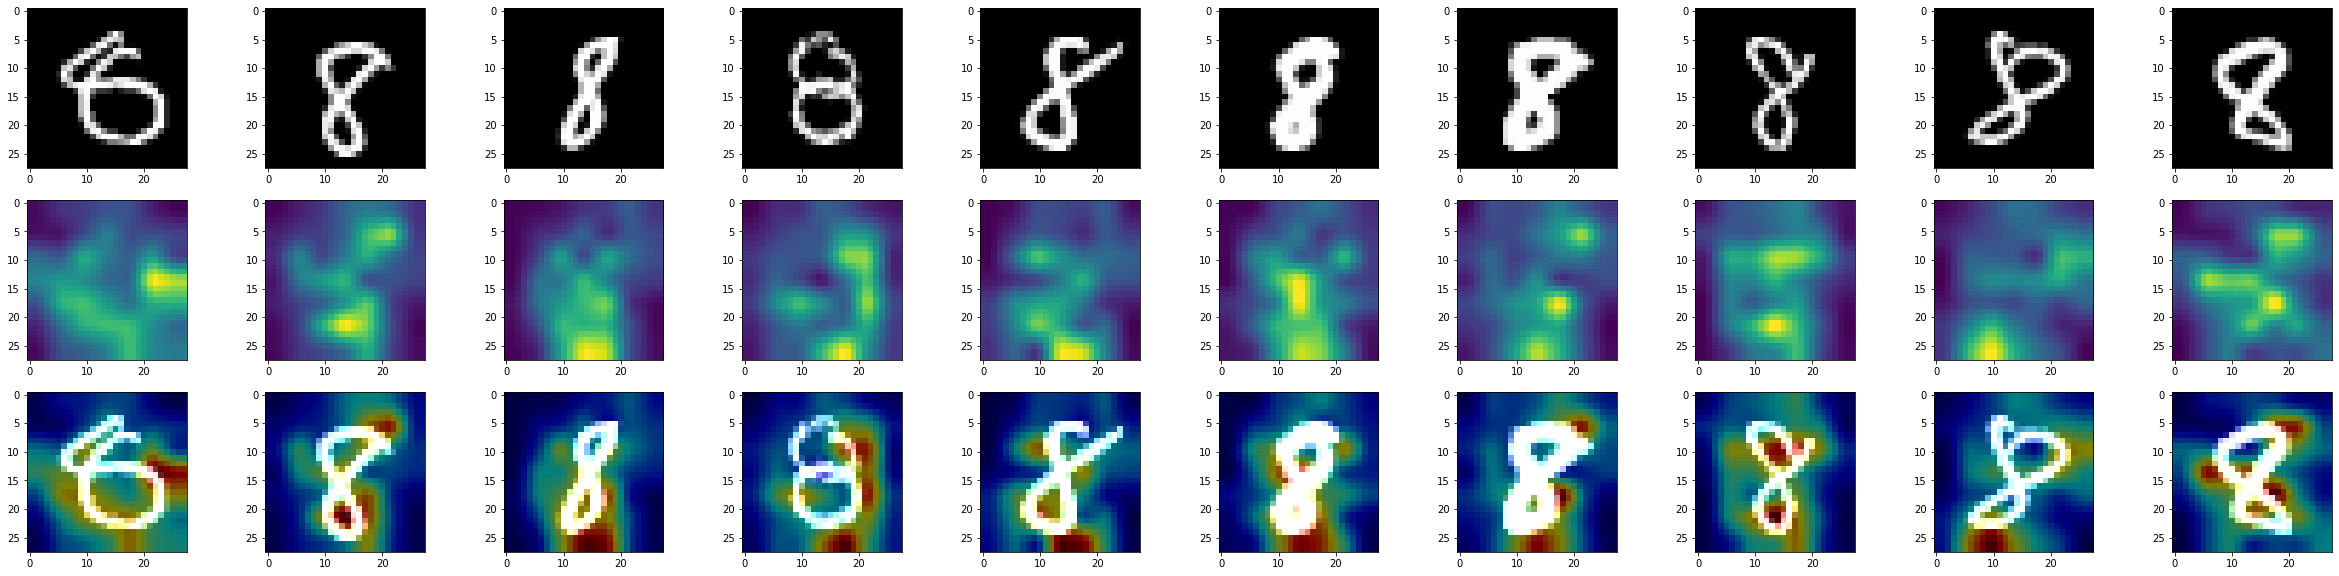



----------------------------------------------




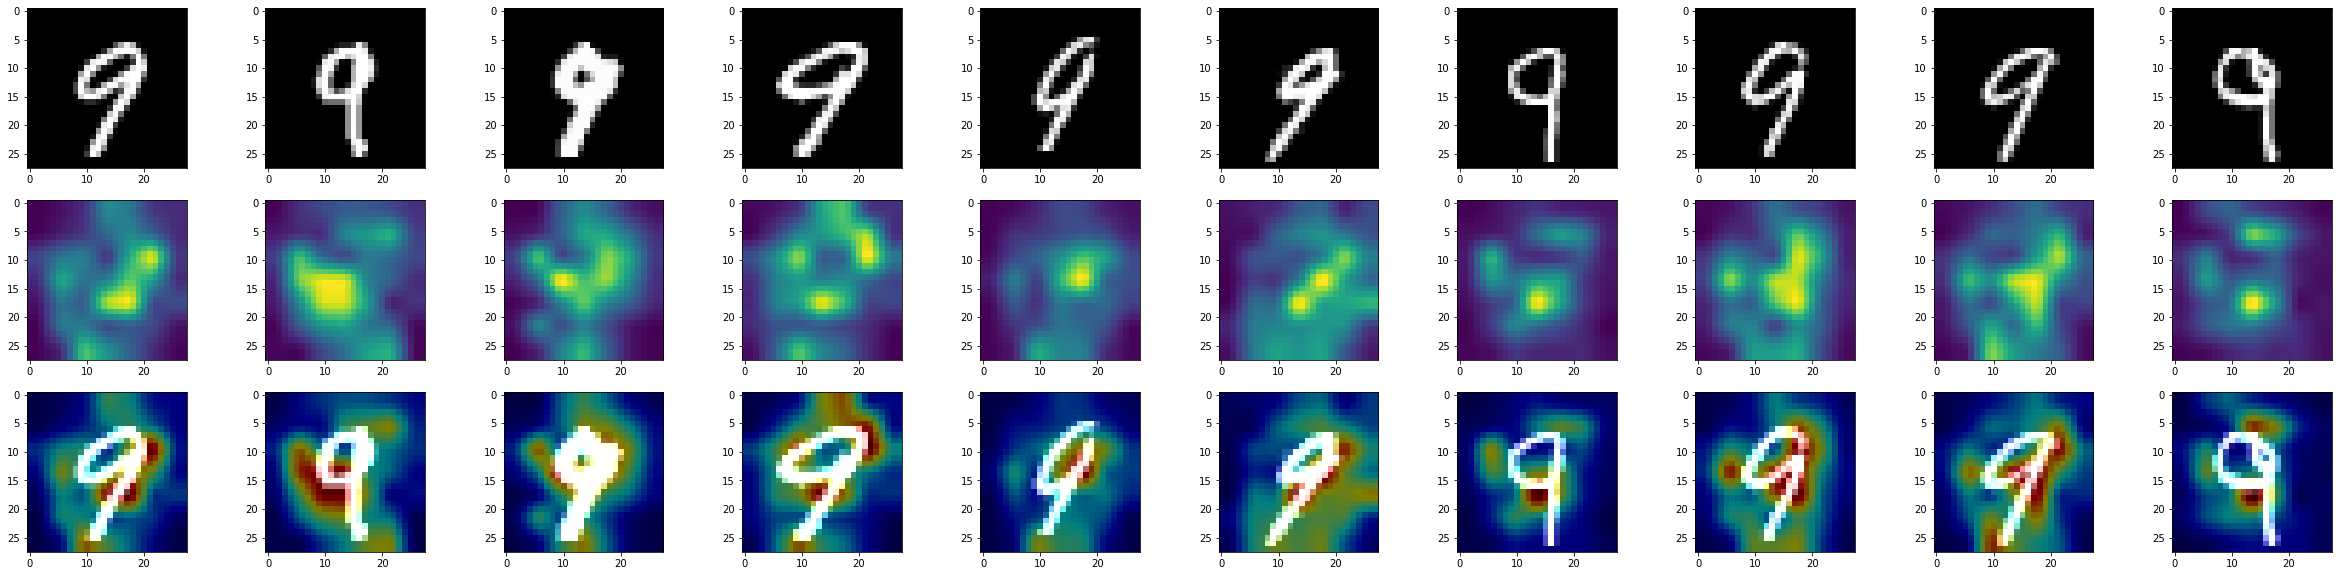



----------------------------------------------




In [12]:
for i in range(10):
  images = []
  c = 0
  while len(images) < 30:
    if y_train[c, i] == 1:
      image = x_train[c]
      
      temp = np.uint8(255 * image)
      temp = cv2.cvtColor(temp, cv2.COLOR_GRAY2RGB)
      images.append(temp)
      
      heatmap = grad_cam(image, 'conv2d_2')
      images.append(heatmap)

      superimposed = superimpose(temp, heatmap)
      images.append(superimposed)
    c+=1
  render_images(images)
  print('\n\n----------------------------------------------\n\n')